<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/CVNL_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import nltk
from nltk.tokenize import word_tokenize
import requests
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [27]:
# get json dataset from github
url = "https://raw.githubusercontent.com/snipsco/nlu-benchmark/master/2016-12-built-in-intents/benchmark_data.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print("Successfully fetched SNIPS dataset")

    # Extract intents and associated text queries
    snips_data = {}
    for domain in data["domains"]:
        for intent in domain["intents"]:
            intent_name = intent["benchmark"]["Snips"]["original_intent_name"]
            queries = [query["text"] for query in intent["queries"]]
            snips_data[intent_name] = queries

    print(f"Total intents: {len(snips_data)}")
    print("Example intent:", list(snips_data.keys())[0])
    print("Example queries:", snips_data[list(snips_data.keys())[0]][:5])
else:
    print("Failed to fetch SNIPS dataset")

Successfully fetched SNIPS dataset
Total intents: 10
Example intent: ShareCurrentLocation
Example queries: ["Share my location with Hillary's sister", 'Send my current location to my father', 'Share my current location with Jim', 'Send my location to my husband', 'Send my location']


In [28]:
all_words = [word for queries in snips_data.values() for query in queries for word in word_tokenize(query.lower())]

# build vocabulary
vocab = {word: idx + 2 for idx, word in enumerate(Counter(all_words))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

# map intent
intent_labels = {intent: idx for idx, intent in enumerate(snips_data.keys())}

def text_to_sequence(text, vocab, max_len=10):
    tokens = [vocab.get(word, vocab["<UNK>"]) for word in word_tokenize(text.lower())]
    return tokens[:max_len] + [vocab["<PAD>"]] * (max_len - len(tokens))

sample_text = "play some jazz music"
print(text_to_sequence(sample_text, vocab))


[1, 257, 212, 1, 0, 0, 0, 0, 0, 0]


In [29]:
class SNIPSDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, intent_labels, max_len=10):
        self.data = data
        self.vocab = vocab
        self.intent_labels = intent_labels
        self.max_len = max_len
        self.samples = [(query, intent) for intent, queries in data.items() for query in queries]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, intent = self.samples[idx]
        tokenized_text = text_to_sequence(text, self.vocab, self.max_len)
        label = self.intent_labels[intent]
        return torch.tensor(tokenized_text), torch.tensor(label)

# create dataset, split into test and evaluation
full_dataset = SNIPSDataset(snips_data, vocab, intent_labels)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [30]:
class IntentBiRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(IntentBiRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, lengths):
        x_embedded = self.embedding(x)

        # pack
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(x_packed)

        # extract last hidden state for both directions
        hidden = hidden.view(self.rnn.num_layers, 2, x.size(0), self.rnn.hidden_size)
        hidden = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1)

        return self.fc(hidden)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntentBiRNN(len(vocab), embed_dim=64, hidden_dim=64, output_dim=len(intent_labels)).to(device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [35]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # reduce lr every 5 epochs

num_epochs = 20
patience = 3
best_val_loss = float("inf")
no_improve = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for texts, labels in pbar:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()

            optimizer.zero_grad()
            outputs = model(texts, lengths)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

            pbar.set_postfix(Loss=f"{loss.item():.4f}")

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(100.0 * correct_train / total_train)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()

            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(100.0 * correct_val / total_val)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    # implement early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        no_improve = 0  # reset
    else:
        no_improve += 1
        print(f"No improvement in validation loss for {no_improve} epoch(s).")

    if no_improve >= patience:
        print("Early stopping triggered.")
        break

    # update learning rate scheduler
    scheduler.step()
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")


Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 107.24batch/s, Loss=0.5915]


Epoch 1:
  Train Loss: 0.5871, Train Accuracy: 90.46%
  Val Loss: 0.7315, Val Accuracy: 63.64%
Learning Rate: 0.001000


Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 102.45batch/s, Loss=0.2140]


Epoch 2:
  Train Loss: 0.4300, Train Accuracy: 95.04%
  Val Loss: 0.6872, Val Accuracy: 66.67%
Learning Rate: 0.001000


Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 106.71batch/s, Loss=0.1559]


Epoch 3:
  Train Loss: 0.3461, Train Accuracy: 96.95%
  Val Loss: 0.6491, Val Accuracy: 68.18%
Learning Rate: 0.001000


Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 111.47batch/s, Loss=0.2325]


Epoch 4:
  Train Loss: 0.2845, Train Accuracy: 98.47%
  Val Loss: 0.6211, Val Accuracy: 71.21%
Learning Rate: 0.001000


Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 98.01batch/s, Loss=0.1389]


Epoch 5:
  Train Loss: 0.2229, Train Accuracy: 100.00%
  Val Loss: 0.6013, Val Accuracy: 72.73%
Learning Rate: 0.000500


Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 93.64batch/s, Loss=0.2308]


Epoch 6:
  Train Loss: 0.1956, Train Accuracy: 100.00%
  Val Loss: 0.5860, Val Accuracy: 75.76%
Learning Rate: 0.000500


Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 84.57batch/s, Loss=0.2064]


Epoch 7:
  Train Loss: 0.1757, Train Accuracy: 100.00%
  Val Loss: 0.5746, Val Accuracy: 75.76%
Learning Rate: 0.000500


Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 84.76batch/s, Loss=0.1711]


Epoch 8:
  Train Loss: 0.1573, Train Accuracy: 100.00%
  Val Loss: 0.5722, Val Accuracy: 77.27%
Learning Rate: 0.000500


Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 87.60batch/s, Loss=0.1187]


Epoch 9:
  Train Loss: 0.1388, Train Accuracy: 100.00%
  Val Loss: 0.5698, Val Accuracy: 77.27%
Learning Rate: 0.000500


Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 89.67batch/s, Loss=0.1161]


Epoch 10:
  Train Loss: 0.1254, Train Accuracy: 100.00%
  Val Loss: 0.5691, Val Accuracy: 77.27%
Learning Rate: 0.000250


Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 93.39batch/s, Loss=0.1545]


Epoch 11:
  Train Loss: 0.1189, Train Accuracy: 100.00%
  Val Loss: 0.5689, Val Accuracy: 77.27%
Learning Rate: 0.000250


Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 93.62batch/s, Loss=0.0893]


Epoch 12:
  Train Loss: 0.1080, Train Accuracy: 100.00%
  Val Loss: 0.5669, Val Accuracy: 77.27%
Learning Rate: 0.000250


Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 99.32batch/s, Loss=0.0882]


Epoch 13:
  Train Loss: 0.1032, Train Accuracy: 100.00%
  Val Loss: 0.5633, Val Accuracy: 77.27%
Learning Rate: 0.000250


Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 96.05batch/s, Loss=0.0787]


Epoch 14:
  Train Loss: 0.0976, Train Accuracy: 100.00%
  Val Loss: 0.5593, Val Accuracy: 78.79%
Learning Rate: 0.000250


Epoch 15/20: 100%|██████████| 9/9 [00:00<00:00, 81.40batch/s, Loss=0.0795]


Epoch 15:
  Train Loss: 0.0936, Train Accuracy: 100.00%
  Val Loss: 0.5565, Val Accuracy: 78.79%
Learning Rate: 0.000125


Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 87.15batch/s, Loss=0.0854]


Epoch 16:
  Train Loss: 0.0907, Train Accuracy: 100.00%
  Val Loss: 0.5557, Val Accuracy: 78.79%
Learning Rate: 0.000125


Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 94.68batch/s, Loss=0.0727]


Epoch 17:
  Train Loss: 0.0875, Train Accuracy: 100.00%
  Val Loss: 0.5542, Val Accuracy: 78.79%
Learning Rate: 0.000125


Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 101.08batch/s, Loss=0.0658]


Epoch 18:
  Train Loss: 0.0849, Train Accuracy: 100.00%
  Val Loss: 0.5534, Val Accuracy: 78.79%
Learning Rate: 0.000125


Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 104.79batch/s, Loss=0.0927]


Epoch 19:
  Train Loss: 0.0856, Train Accuracy: 100.00%
  Val Loss: 0.5517, Val Accuracy: 78.79%
Learning Rate: 0.000125


Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 103.74batch/s, Loss=0.0486]


Epoch 20:
  Train Loss: 0.0798, Train Accuracy: 100.00%
  Val Loss: 0.5517, Val Accuracy: 78.79%
Learning Rate: 0.000063


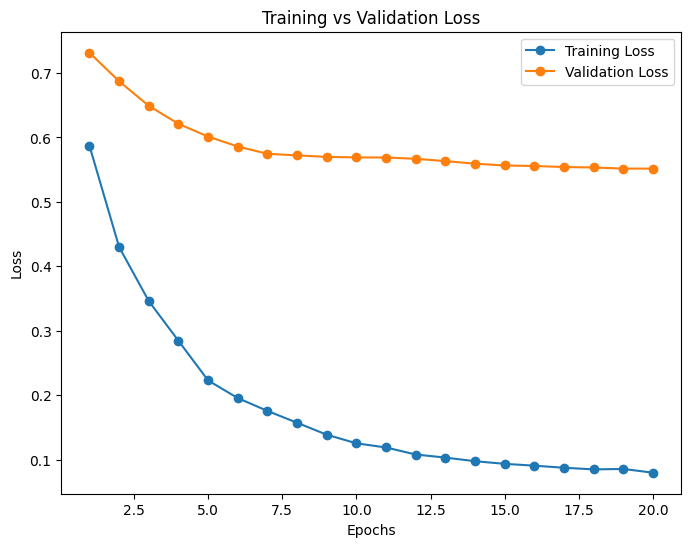

In [36]:
plt.figure(figsize=(8, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [37]:
def predict_intent(text, model, vocab, intent_labels):
    model.eval()

    tokenized = text_to_sequence(text, vocab)
    input_tensor = torch.tensor(tokenized).unsqueeze(0).to(device)
    length = torch.tensor([len(tokenized)], dtype=torch.int64).cpu()

    with torch.no_grad():
        output = model(input_tensor, length)
        predicted_label_idx = torch.argmax(output, dim=1).item()
    predicted_label = [key for key, value in intent_labels.items() if value == predicted_label_idx][0]
    return predicted_label

print(predict_intent("play some music", model, vocab, intent_labels))
print(predict_intent("turn on the lights", model, vocab, intent_labels))
print(predict_intent("book a flight to New York", model, vocab, intent_labels))


GetDirections
GetDirections
RequestRide


In [38]:
# Import necessary libraries
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def generate_rnn_classification_report(model, dataloader, device, class_names):
    """
    Evaluates the RNN model using accuracy, precision, recall, and F1-score.
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()  # Get actual lengths

            # Get model predictions
            outputs = model(texts, lengths)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Define class names from the SNIPS dataset
class_names = list(intent_labels.keys())

# Call the classification report function
generate_rnn_classification_report(model, val_loader, device, class_names)


Classification Report:
                       precision    recall  f1-score   support

 ShareCurrentLocation       0.56      1.00      0.71         5
        ComparePlaces       0.50      0.50      0.50         2
      GetPlaceDetails       0.57      0.89      0.70         9
          SearchPlace       1.00      0.67      0.80         3
       BookRestaurant       1.00      0.92      0.96        12
          RequestRide       1.00      0.80      0.89         5
        GetDirections       0.90      0.82      0.86        11
             ShareETA       1.00      0.33      0.50         6
GetTrafficInformation       0.75      0.75      0.75         4
           GetWeather       0.88      0.78      0.82         9

             accuracy                           0.79        66
            macro avg       0.82      0.75      0.75        66
         weighted avg       0.84      0.79      0.79        66

Accuracy: 0.7879
Precision: 0.8439
Recall: 0.7879
F1-Score: 0.7878


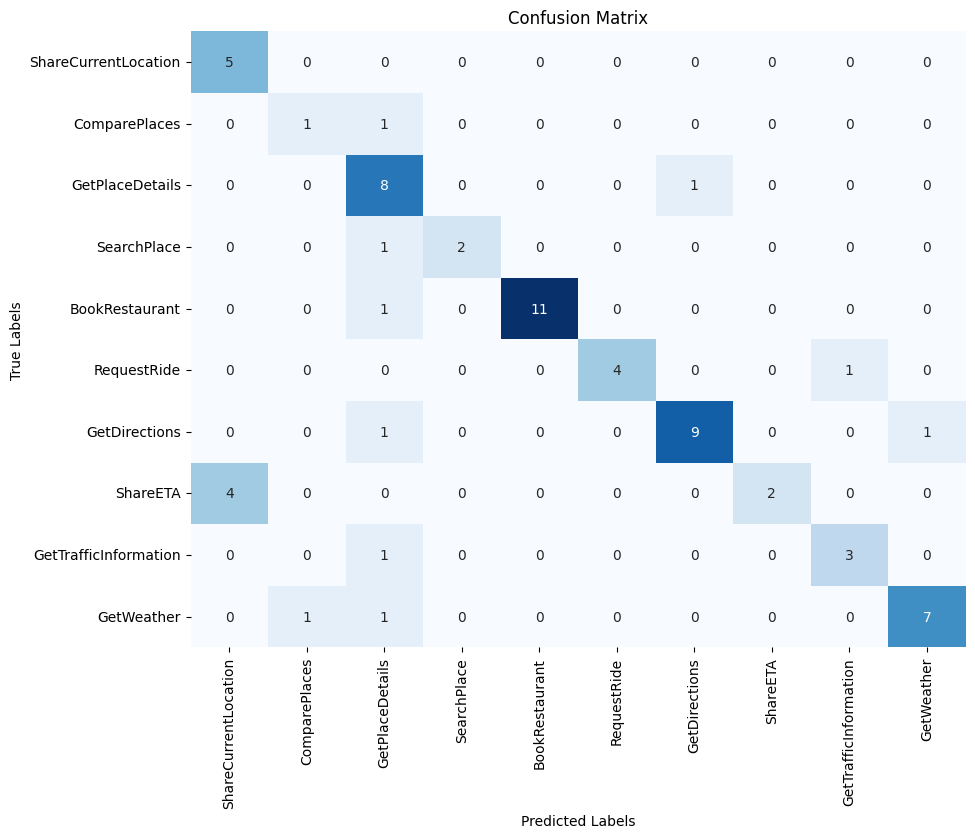

In [39]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix

def plot_rnn_confusion_matrix(model, dataloader, device, class_names):
    """
    Plots the confusion matrix to visualize misclassifications.
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()  # Get actual lengths

            # Get model predictions
            outputs = model(texts, lengths)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the confusion matrix function
plot_rnn_confusion_matrix(model, val_loader, device, class_names)